# Train a scVI model using Census data

This notebook demonstrates a scalable approach to training an [scVI](https://docs.scvi-tools.org/en/latest/user_guide/models/scvi.html) model on Census data. The [scvi-tools](https://scvi-tools.org/) library is built around [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/). [TileDB-SOMA-ML](https://github.com/single-cell-data/TileDB-SOMA-ML) assists with streaming Census query results to PyTorch in batches, allowing for training datasets larger than available RAM.

## Plan for this tutorial

1. Training the model
2. Generate cell embeddings
3. Analyzing the results

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


## Training the model 

Let's start by importing the necessary dependencies.

In [2]:
import warnings

import cellxgene_census
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import tiledbsoma as soma
from cellxgene_census.experimental.pp import highly_variable_genes

# from lightning import LightningDataModule
# from sklearn.preprocessing import LabelEncoder
# from torch.utils.data import DataLoader
from scvi.dataloaders import TileDBDataModule

warnings.filterwarnings("ignore")

→ connected lamindb: anonymous/lamindb_collection_scanvi


We'll now prepare the necessary parameters for running a training pass of the model.

For this notebook, we'll use a stable version of the Census:

In [3]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

We'll also do two types of filtering.

For **cells**, we will apply a filter to only select primary cells, with at least 300 expressed genes (nnz >= 300). For notebook demonstration purposes, we will also apply a tissue filtering so that the training can happen on a laptop. The same approach can be used on datasets much larger than available RAM. (A GPU is recommended, though.)

For **genes**, we will apply a filter so that only the top highly variable genes (HVG) are included in the training. This is a commonly used dimensionality reduction approach and is recommended on production models as well.

Let's define a few parameters:

In [4]:
experiment_name = "mus_musculus"

In [5]:
# obs_val_filt = ('is_primary_data == True and tissue_general in ["spleen", "kidney"] '
#            'and nnz >= 500')
# obs_val_filt = ('is_primary_data == True and tissue_general in ["kidney"] '
#            'and nnz >= 500 and donor_id not in ["pooled"]')
# obs_val_filt = ('is_primary_data == True and tissue_general in ["liver", "heart"] '
#            'and nnz >= 500')
obs_val_filt = (
    'is_primary_data == True and cell_type in ["B cell","T cell", "macrophage","fibroblast","endothelial","myeloid","lymphocyte","natural killer cell","CD4-positive, alpha-beta T cell","CD8-positive, alpha-beta T cell"] '
    'and donor_id not in ["pooled"] and dataset_id in ["58b01044-c5e5-4b0f-8a2d-6ebf951e01ff","48b37086-25f7-4ecd-be66-f5bb378e3aea"] and tissue_general not in ["vasculature","skeletal system","skin of body"] and nnz >= 300'
)
# obs_val_filt = ('is_primary_data == True and tissue_general in ["blood"] '
#            'and nnz >= 500 and dataset_id in ["9dbab10c-118d-496b-966a-67f1763a6b7d"]')

We define the batch to be a multivariate parameters

In [6]:
batch_keys = [
    "dataset_id",
    "donor_id",
    "assay",
    "tissue_general",
]  # ,"tissue_general","assay", "dataset_id", "disease"

For HVG, we can use the `highly_variable_genes` function provided in `cellxgene_census`, which can compute HVGs in constant memory:

In [7]:
top_n_hvg = 5000
hvgs_df = highly_variable_genes(
    census["census_data"][experiment_name].axis_query(
        measurement_name="RNA", obs_query=soma.AxisQuery(value_filter=obs_val_filt)
    ),
    n_top_genes=top_n_hvg,
    batch_key=batch_keys,
)
hv = hvgs_df.highly_variable
hv_idx = hv[hv].index
# hv_idx = np.arange(10)

Once we know the id's of the HVG's we can select only them using the tiledb query mechanism

In [8]:
hvg_query = census["census_data"][experiment_name].axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(value_filter=obs_val_filt),
    var_query=soma.AxisQuery(coords=(list(hv_idx),)),
)

We will now introduce a helper class `TileDBDataModule` to connect SCVI with TileDB-SOMA-ML with PyTorch Lightning. It subclasses [`LightningDataModule`](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) and:

1. Uses TileDB-SOMA-ML to prepare a DataLoader for the results of a SOMA [`ExperimentAxisQuery`](https://tiledbsoma.readthedocs.io/en/1.15.0/python-tiledbsoma-experimentaxisquery.html) on the Census.
1. Derives each cell's scVI batch label as a tuple of obs attributes: `dataset_id`, `donor_id`.
    * *Don't confuse each cell's label for scVI "batch" integration with a training data "batch" generated by the DataLoader.*
1. Converts the RNA counts and batch labels to a dict of tensors for each training data batch, as scVI expects.

In [9]:
datamodule = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_size=1024,
    shuffle=True,
    seed=42,
    batch_column_names=batch_keys,
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
    accelerator="gpu",
    device=1,
    return_sparse_X=False,
)
print(datamodule.n_obs, datamodule.n_vars, datamodule.n_batch)

99861 5000 148


Most parameters to `TileDBDataModule` are passed through to the [`tiledbsoma_ml.ExperimentDataset`](https://single-cell-data.github.io/TileDB-SOMA-ML/#tiledbsoma_ml.ExperimentDataset) initializer; see that documentation to understand how it can be tuned.

In particular, here are some parameters of interest:

* `shuffle`: shuffles the result cell order, which is often advisable for model training.
* `batch_size`: controls the size (number of cells) in each training data batch, in turn controlling memory usage.
* `dataloader_kwargs`: [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) tuning, for example controlling parallelization.

We can now create the scVI model object:

In [10]:
n_layers = 1
n_latent = 10
datamodule.setup()
model = scvi.model.SCVI(
    adata=None,
    registry=datamodule.registry,
    n_layers=n_layers,
    n_latent=n_latent,
)

In [11]:
# creating the dataloader for trainset
# training_dataloader = (
#    datamodule.on_before_batch_transfer(batch, None) for batch in datamodule.train_dataloader()
# )

In [12]:
import gc

gc.collect()
# del model
# del datamodule

43627

Then, we can invoke the `.train` method which will start the training loop.

In [13]:
import time

start = time.time()
model.train(
    datamodule=datamodule,
    max_epochs=40,
    batch_size=1024,
    plan_kwargs={"lr": 2e-2},
    early_stopping=False,
    # accelerator="gpu",
    # devices=-1,
    # strategy="ddp_find_unused_parameters_true",
)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/40 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


Elapsed time: 11299.79 seconds


In [14]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

In [15]:
model.history["elbo_train"].tail()

elbo_train
epoch             
35     2211.021484
36     2210.543213
37     2210.179932
38     2209.786621
39      2209.20752

We can now save the trained model. As of the current writing, scvi-tools doesn't support saving a model that wasn't generated through an AnnData loader, so we'll use some custom code:

In [16]:
model.save("census_model", save_anndata=False, overwrite=True, datamodule=datamodule)

We will now load the model back and use it to generate cell embeddings (the latent space), which can then be used for further analysis. Loading the model similarly involves some custom code.

In [17]:
# scvi.model.SCVI.load("census_model", adata=False)

## Generate cell embeddings

We will now generate the cell embeddings for this model, using the `get_latent_representation` function available in scvi-tools. 

We can use another instance of the `SCVIDataModule` for the forward pass, so we don't need to load the whole dataset in memory. This will have shuffling disabled to make it easier to join the embeddings later. We also want to restore the list of scVI batch labels from the training data, ensuring our forward pass will map batch labels to tensors in the expected way (although this specific example would work regardless, since it reuses the same query).

In [18]:
inference_datamodule = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_labels=datamodule.batch_labels,
    batch_size=1024,
    shuffle=False,
    batch_column_names=batch_keys,
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
)
inference_datamodule.setup()

To feed the data to `get_latent_representation`, we operate `inference_datamodule` as PyTorch Lightning would during training:

In [19]:
latent = model.get_latent_representation(dataloader=inference_datamodule.inference_dataloader())
latent.shape

(99861, 10)

We successfully trained the model and generated embeddings using limited memory. Even on the full Census, this has been tested to run with less than 30G of memory.

## Analyzing the results

We will now take a look at the UMAP for the generated embedding. Note that we need to extract the adata out of the census data.

In order to do this, we'll use `scanpy` which accepts an AnnData object, so we'll generate one using the `get_anndata` utility function:

In [20]:
adata = cellxgene_census.get_anndata(
    census,
    organism=experiment_name,
    obs_value_filter=obs_val_filt,
)

Add the generated embedding (stored in `latent`) in the obsm slot of the AnnData object:

In [21]:
# verify cell order:
assert np.array_equal(
    np.array(adata.obs["soma_joinid"]), inference_datamodule.train_dataset.query_ids.obs_joinids
)

adata.obsm["scvi"] = latent

We can now generate the neighbors and the UMAP.

In [22]:
# adata = adata[~adata.obs["cell_type"].str.contains("kidney", na=False)]
# adata.obs.loc[adata.obs.cell_type.isin(["CD8-positive, alpha-beta T cell","CD4-positive, alpha-beta T cell"],"cell_type"] = "T cell"

In [23]:
sc.pp.neighbors(adata, use_rep="scvi", key_added="scvi")
sc.tl.umap(adata, neighbors_key="scvi")

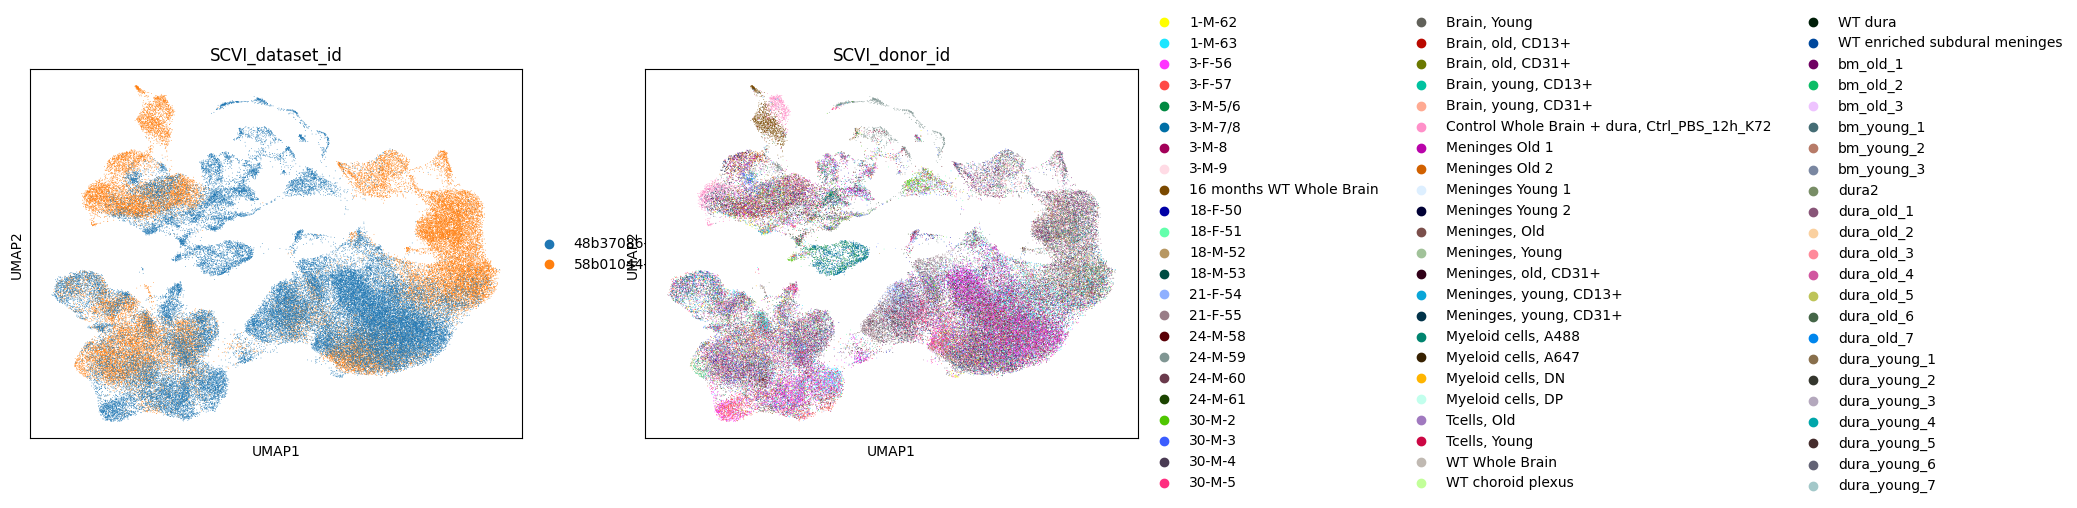

In [24]:
sc.pl.umap(
    adata,
    color=["dataset_id", "donor_id"],
    title=["SCVI_" + x for x in ["dataset_id", "donor_id"]],
)

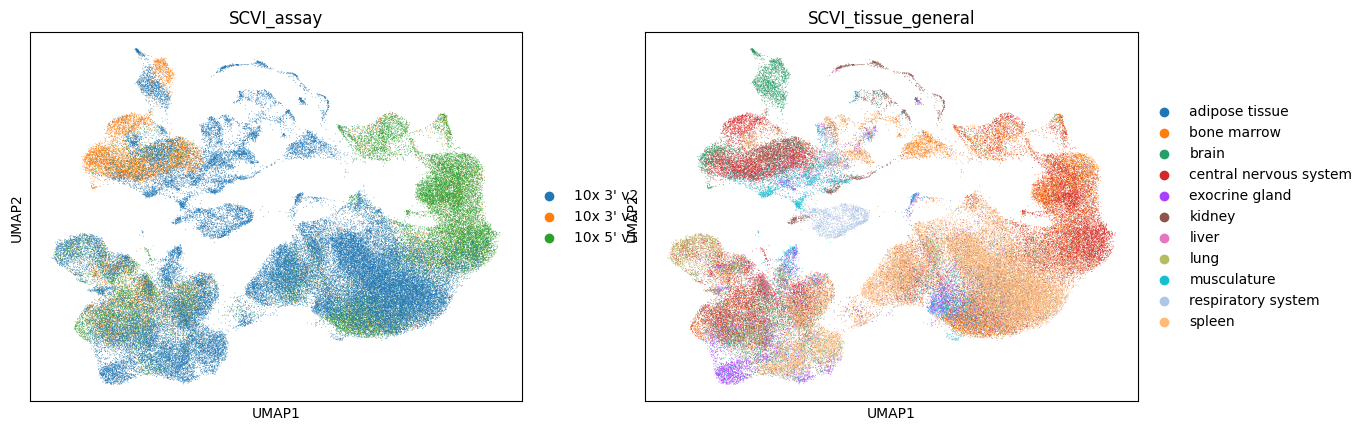

In [25]:
sc.pl.umap(
    adata,
    color=["assay", "tissue_general"],
    title=["SCVI_" + x for x in ["assay", "tissue_general"]],
)

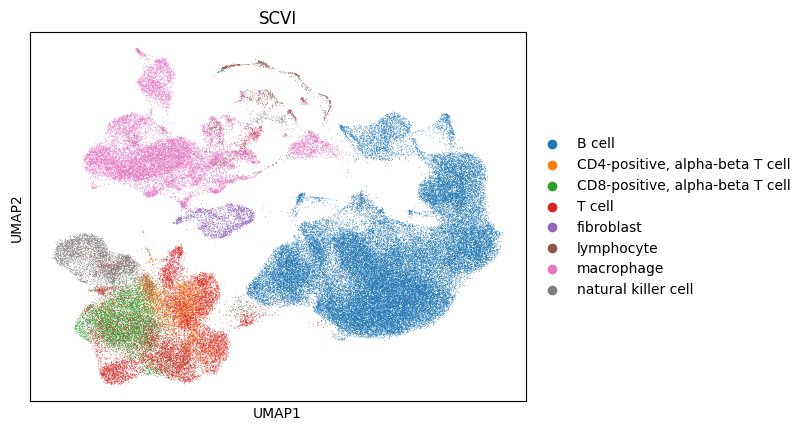

In [26]:
sc.pl.umap(adata, color="cell_type", title="SCVI")

lets train the actual adata that we extracted the normal way in order to see the integration 

In [27]:
adata.obs["batch"] = adata.obs[batch_keys].agg("//".join, axis=1).astype("category")

In [28]:
adata.obs["batch"].nunique()

148

In [29]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [30]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=top_n_hvg,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="dataset_id",
)

In [31]:
adata

AnnData object with n_obs × n_vars = 99861 × 5000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'scvi', 'umap', 'dataset_id_colors', 'donor_id_colors', 'assay_colors', 'tissue_general_colors', 'cell_type_colors', 'log1p', 'hvg'
    obsm: 'scvi', 'X_umap'
    layers: 'counts'
    obsp: 'scvi_d

In [32]:
# pd.crosstab(adata.obs["assay"],adata.obs["dataset_id"], margins=True)

In [33]:
# pd.crosstab(adata.obs["assay"],adata.obs["dataset_id"], margins=True)

In [34]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", categorical_covariate_keys=batch_keys)

In [35]:
# model_census3 = scvi.model.SCVI.load("census_model", adata=adata)
model_census3 = scvi.model.SCVI(adata)

In [36]:
start2 = time.time()
model_census3.train(
    max_epochs=100,
)
end2 = time.time()
print(f"Elapsed time: {end2 - start2:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 315.05 seconds


In [37]:
model_census3.history["elbo_train"].tail()

elbo_train
epoch             
95     1092.661743
96     1092.535889
97     1092.518921
98     1092.366455
99     1092.300659

In [38]:
adata.obsm["scvi_non_dataloder"] = model_census3.get_latent_representation()

In [39]:
sc.pp.neighbors(adata, use_rep="scvi_non_dataloder", key_added="scvi_non_dataloder")
sc.tl.umap(adata, neighbors_key="scvi_non_dataloder")

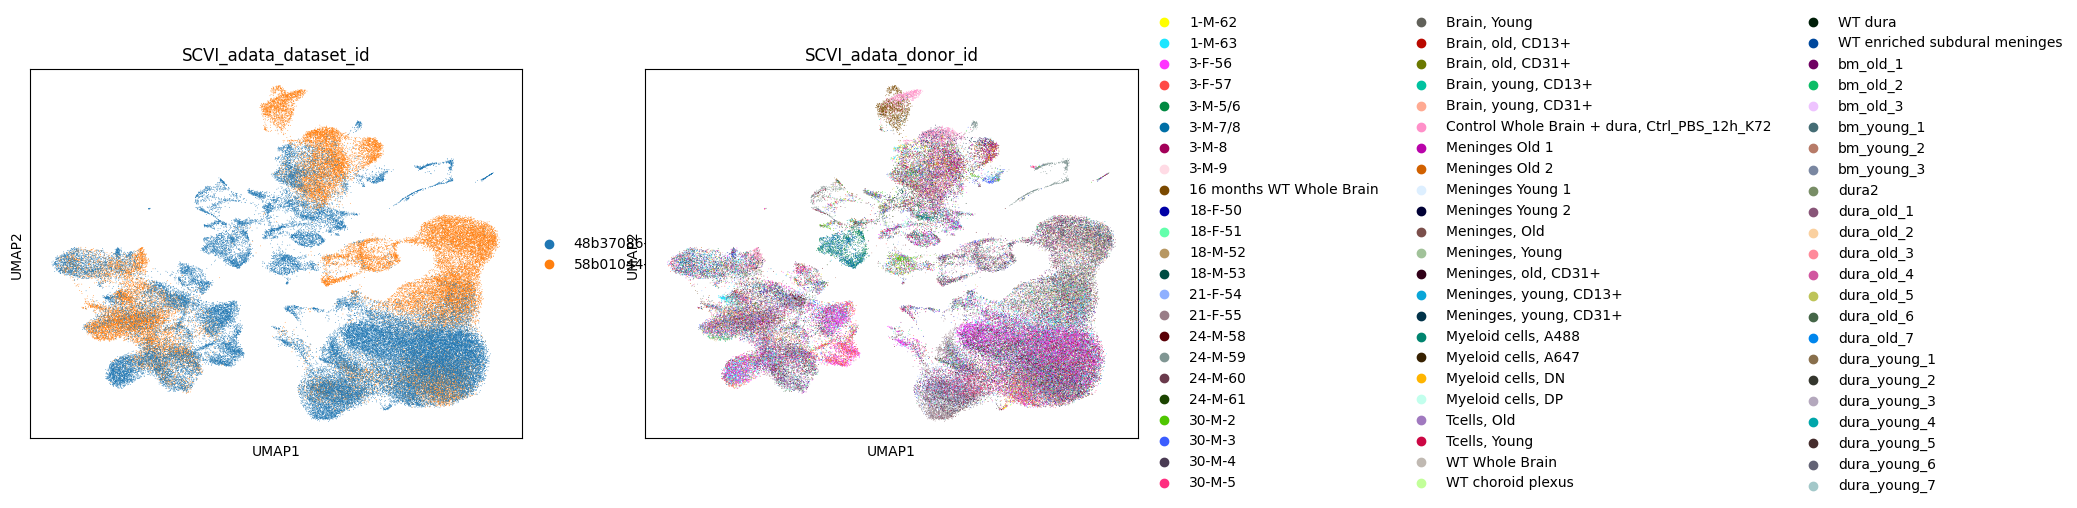

In [40]:
sc.pl.umap(
    adata,
    color=["dataset_id", "donor_id"],
    title=["SCVI_adata_" + x for x in ["dataset_id", "donor_id"]],
)

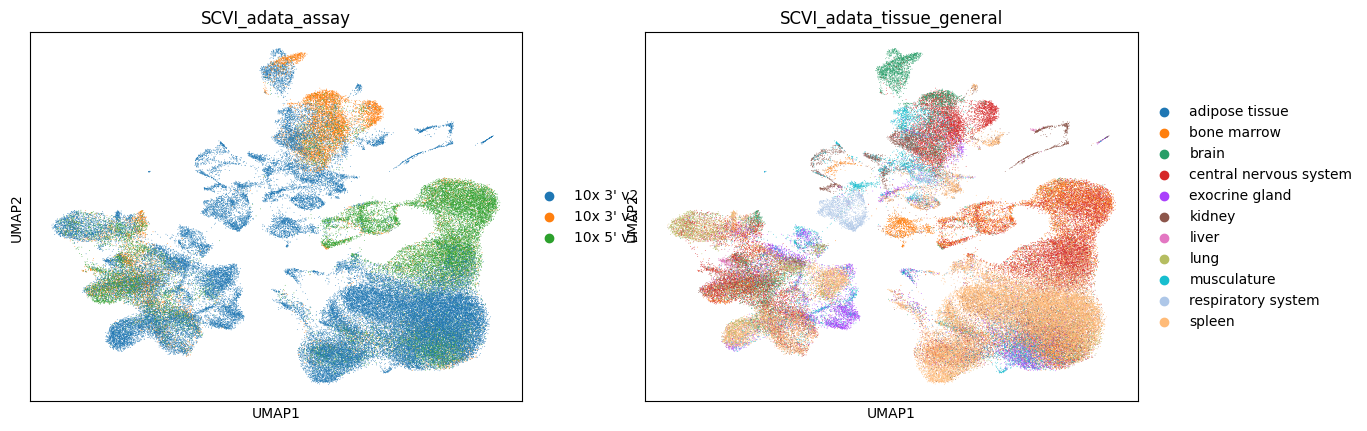

In [41]:
sc.pl.umap(
    adata,
    color=["assay", "tissue_general"],
    title=["SCVI_adata_" + x for x in ["assay", "tissue_general"]],
)

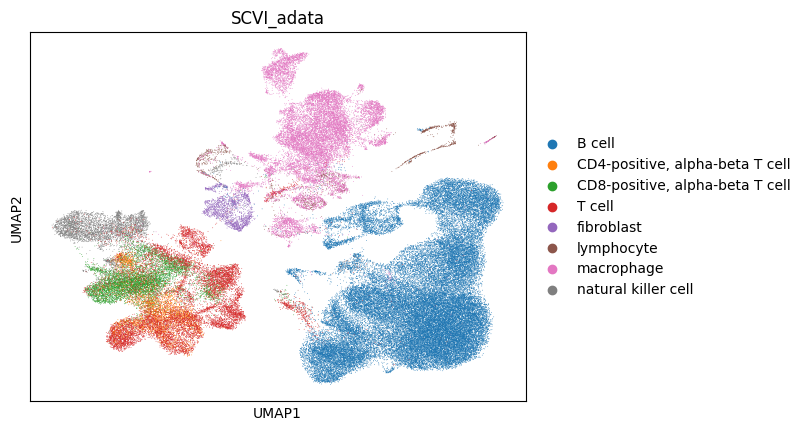

In [42]:
sc.pl.umap(adata, color="cell_type", title="SCVI_adata")

## SCANVI

In [43]:
import gc

gc.collect()
# del model_scanvi
# del datamodule_scanvi

26246

In [44]:
label_keys = ["cell_type"]
datamodule_scanvi = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_size=8192,
    shuffle=True,
    seed=42,
    batch_column_names=batch_keys,
    label_keys=label_keys,
    unlabeled_category="label_0",
    model_name="SCANVI",
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
)
print(
    datamodule_scanvi.n_obs,
    datamodule_scanvi.n_vars,
    datamodule_scanvi.n_batch,
    datamodule_scanvi.n_labels,
)

99861 5000 148 9


In [45]:
datamodule_scanvi.label_keys

['cell_type']

In [46]:
# datamodule_scanvi.registry

In [47]:
# datamodule.registry

In [48]:
# We can now create the scanVI model object and train it:
datamodule_scanvi.setup()
model_scanvi = scvi.model.SCANVI(
    adata=None,
    registry=datamodule_scanvi.registry,
    n_layers=n_layers,
    n_latent=n_latent,
    gene_likelihood="nb",
    encode_covariates=False,
    datamodule=datamodule_scanvi,
)

In [49]:
# model_scanvi = scvi.model.SCANVI.from_scvi_model(
#    scvi_model=model,
#    adata=None,
#    registry=datamodule_scanvi.registry,
#    encode_covariates=False,
#    labels_key="cell_type",
#    unlabeled_category="Unknown",
#    datamodule=datamodule_scanvi,
# )

In [50]:
start3 = time.time()
model_scanvi.train(
    datamodule=datamodule_scanvi,
    max_epochs=100,
    batch_size=1024,
    plan_kwargs={"lr": 1e-3},
    early_stopping=False,
    n_samples_per_label=100,
)
end3 = time.time()
print(f"Elapsed time: {end3 - start3:.2f} seconds")

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 26865.80 seconds


In [51]:
model_scanvi.history.keys()

dict_keys(['train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'train_classification_loss', 'train_accuracy', 'train_f1_score', 'train_calibration_error'])

In [52]:
model_scanvi.history["train_accuracy"].tail()

train_accuracy
epoch               
95          0.995043
96          0.995293
97          0.995043
98          0.995344
99          0.995664

In [53]:
model_scanvi.history["train_f1_score"].tail()

train_f1_score
epoch               
95          0.995043
96          0.995293
97          0.995043
98          0.995344
99          0.995664

In [54]:
model_scanvi.save(
    "census_model_scanvi", save_anndata=False, overwrite=True, datamodule=datamodule_scanvi
)

In [55]:
label_keys

['cell_type']

In [63]:
# Generate cell embeddings
inference_datamodule_scanvi = TileDBDataModule(
    hvg_query,
    layer_name="raw",
    batch_labels=datamodule_scanvi.batch_labels,
    batch_size=1024,
    shuffle=False,
    batch_column_names=batch_keys,
    label_keys=label_keys,
    unlabeled_category="label_0",
    model_name="SCANVI",
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
)
inference_datamodule_scanvi.setup()

In [64]:
# verify cell order:
assert np.array_equal(
    np.array(adata.obs["soma_joinid"]),
    inference_datamodule_scanvi.train_dataset.query_ids.obs_joinids,
)

In [65]:
latent_scanvi = model_scanvi.get_latent_representation(
    dataloader=inference_datamodule_scanvi.inference_dataloader()
)
latent_scanvi.shape

(99861, 10)

In [94]:
# from pprint import pprint
# pprint(model_scanvi.registry)

In [67]:
# adata.obs

In [68]:
adata.obsm["scanvi"] = latent_scanvi

In [69]:
sc.pp.neighbors(adata, use_rep="scanvi", key_added="scanvi")
sc.tl.umap(adata, neighbors_key="scanvi")

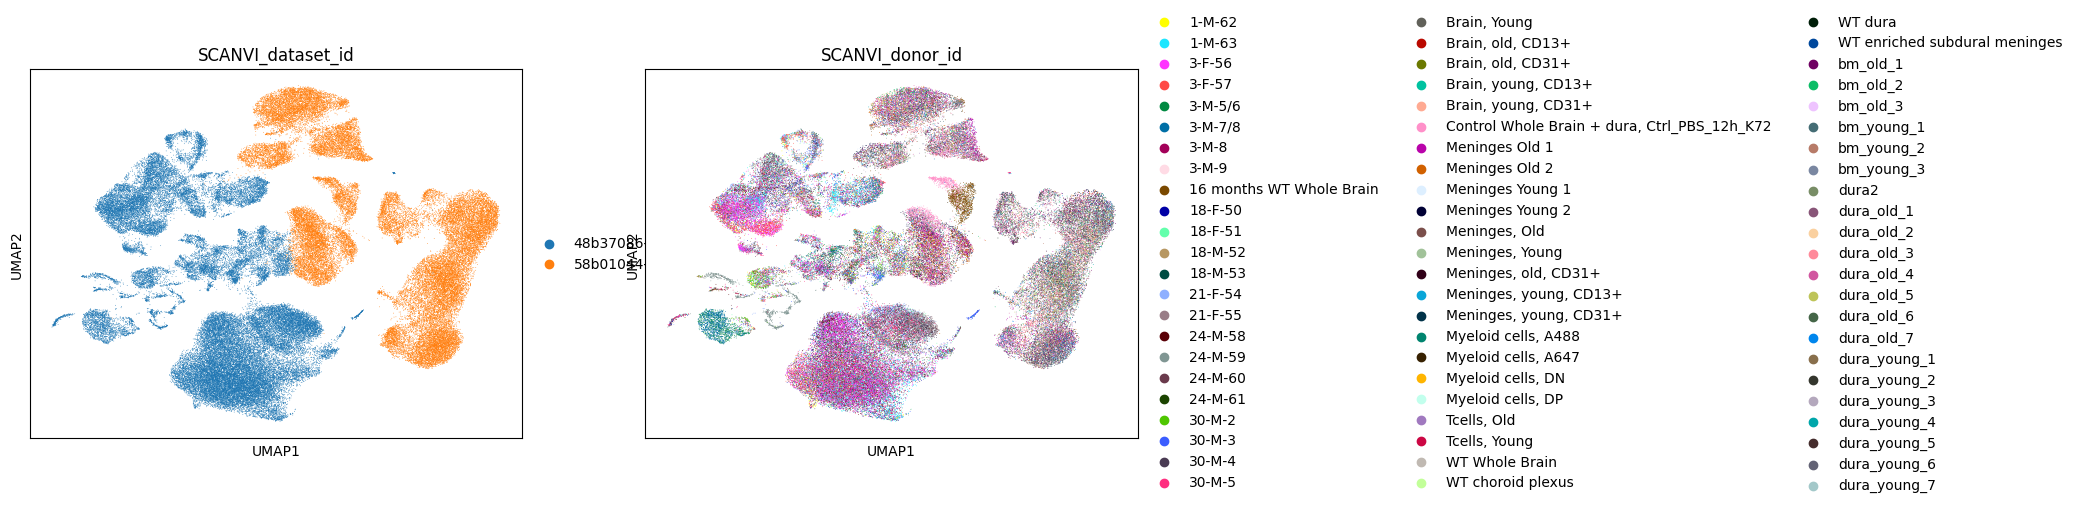

In [70]:
sc.pl.umap(
    adata,
    color=["dataset_id", "donor_id"],
    title=["SCANVI_" + x for x in ["dataset_id", "donor_id"]],
)

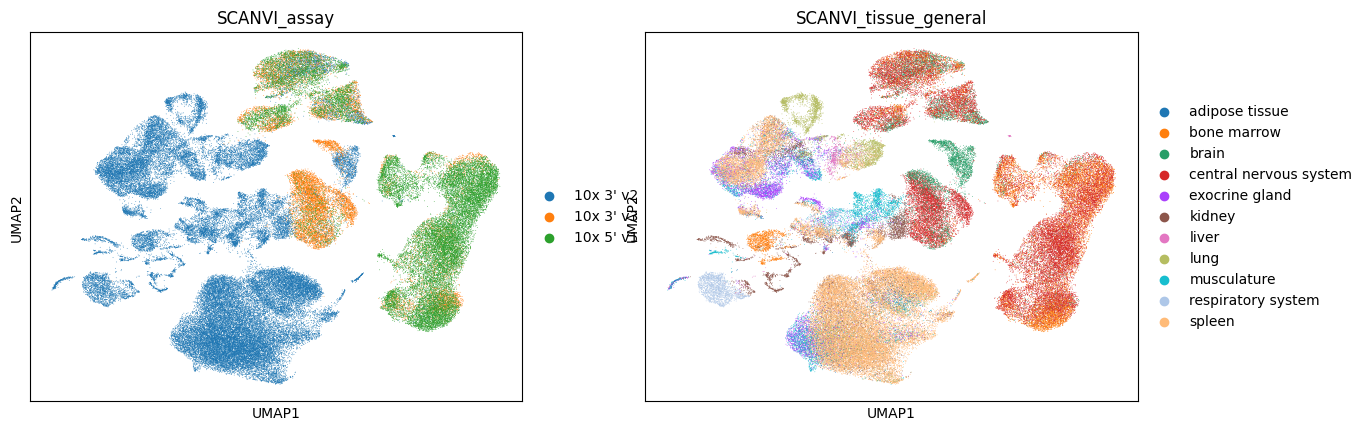

In [71]:
sc.pl.umap(
    adata,
    color=["assay", "tissue_general"],
    title=["SCANVI_" + x for x in ["assay", "tissue_general"]],
)

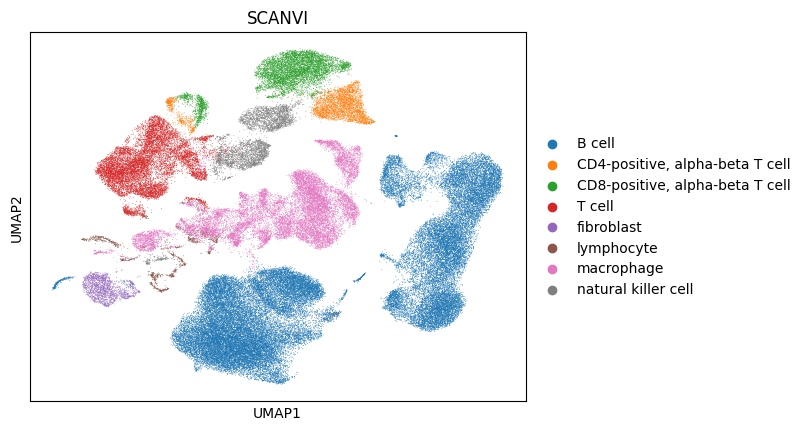

In [72]:
sc.pl.umap(adata, color="cell_type", title="SCANVI")

Calculate Predictions

In [74]:
adata.obs["predictions_scanvi"] = model_scanvi.predict(
    dataloader=inference_datamodule_scanvi.inference_dataloader()
)

In [75]:
adata.obs["cell_type"].value_counts()

cell_type
B cell                             53571
macrophage                         16210
T cell                             11354
CD8-positive, alpha-beta T cell     6867
natural killer cell                 4575
CD4-positive, alpha-beta T cell     3919
fibroblast                          1813
lymphocyte                          1552
Name: count, dtype: int64

In [76]:
adata.obs["predictions_scanvi"].value_counts()

predictions_scanvi
B cell                             53555
lymphocyte                         16239
T cell                             11350
CD8-positive, alpha-beta T cell     6885
macrophage                          4601
CD4-positive, alpha-beta T cell     3891
fibroblast                          1820
label_0                             1520
Name: count, dtype: int64

In [77]:
pd.crosstab(adata.obs["predictions_scanvi"], adata.obs["cell_type"])

cell_type                        B cell  CD4-positive, alpha-beta T cell  \
predictions_scanvi                                                         
B cell                            53525                                0   
CD4-positive, alpha-beta T cell       3                             3885   
CD8-positive, alpha-beta T cell       2                               29   
T cell                                0                                3   
fibroblast                            9                                0   
label_0                              14                                0   
lymphocyte                           16                                0   
macrophage                            2                                2   

cell_type                        CD8-positive, alpha-beta T cell  T cell  \
predictions_scanvi                                                         
B cell                                                         1       7   
CD4-positive, alpha-beta T cell                                3       0   
CD8-positive, alpha-beta T cell                             6853       0   
T cell                                                         0   11320   
fibroblast                                                     0       0   
label_0                                                        0       7   
lymphocyte                                                     0      12   
macrophage                                                    10       8   

cell_type                        fibroblast  lymphocyte  macrophage  \
predictions_scanvi                                                    
B cell                                    0           9          13   
CD4-positive, alpha-beta T cell           0           0           0   
CD8-positive, alpha-beta T cell           0           0           1   
T cell                                    0          25           1   
fibroblast                             1811           0           0   
label_0                                   0        1499           0   
lymphocyte                                2          17       16190   
macrophage                                0           2           5   

cell_type                        natural killer cell  
predictions_scanvi                                    
B cell                                             0  
CD4-positive, alpha-beta T cell                    0  
CD8-positive, alpha-beta T cell                    0  
T cell                                             1  
fibroblast                                         0  
label_0                                            0  
lymphocyte                                         2  
macrophage                                      4572

Text(0, 0.5, 'Observed')

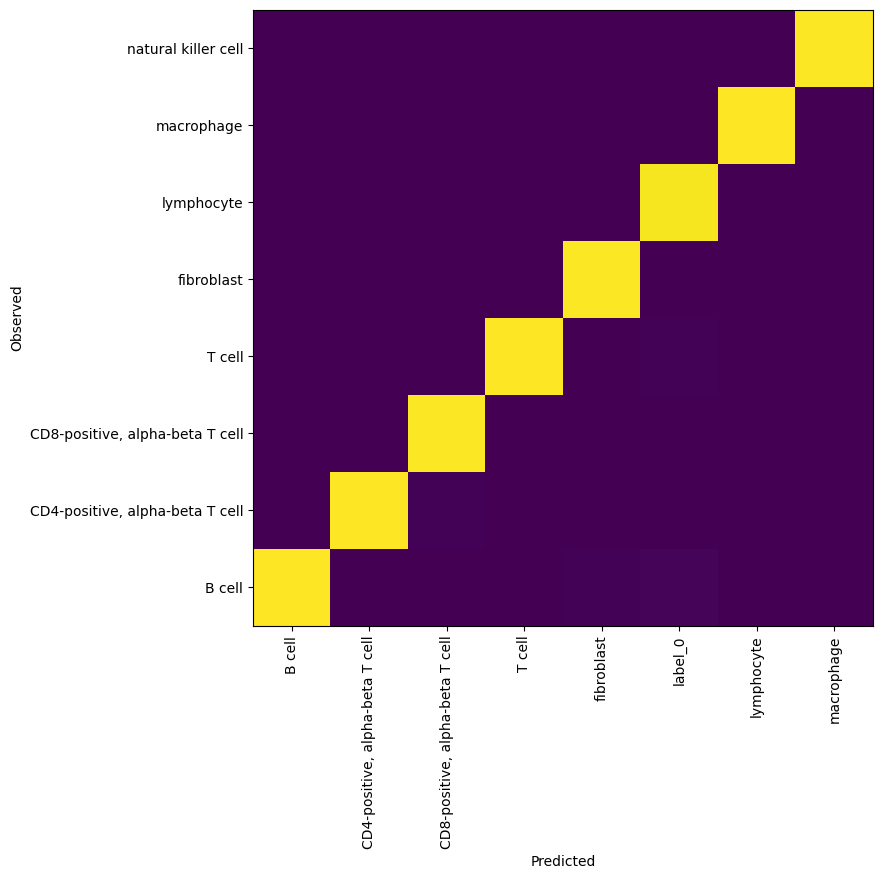

In [78]:
df = adata.obs.groupby(["cell_type", "predictions_scanvi"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

## Compare to regular SCANVI

In [79]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    labels_key="cell_type",
    unlabeled_category="label_0",
    categorical_covariate_keys=batch_keys,
)

In [80]:
# model_census4 = scvi.model.SCVI.load("census_model", adata=adata)
model_census4 = scvi.model.SCANVI(adata)

In [81]:
start4 = time.time()
model_census4.train(
    max_epochs=100,
)
end4 = time.time()
print(f"Elapsed time: {end4 - start4:.2f} seconds")

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 769.57 seconds


In [82]:
model_census4.history["train_accuracy"].tail()

train_accuracy
epoch               
95          0.997908
96          0.997697
97          0.997997
98          0.997474
99          0.997452

In [83]:
adata.obsm["scanvi_non_dataloder"] = model_census4.get_latent_representation()

In [84]:
sc.pp.neighbors(adata, use_rep="scanvi_non_dataloder", key_added="scanvi_non_dataloder")
sc.tl.umap(adata, neighbors_key="scanvi_non_dataloder")

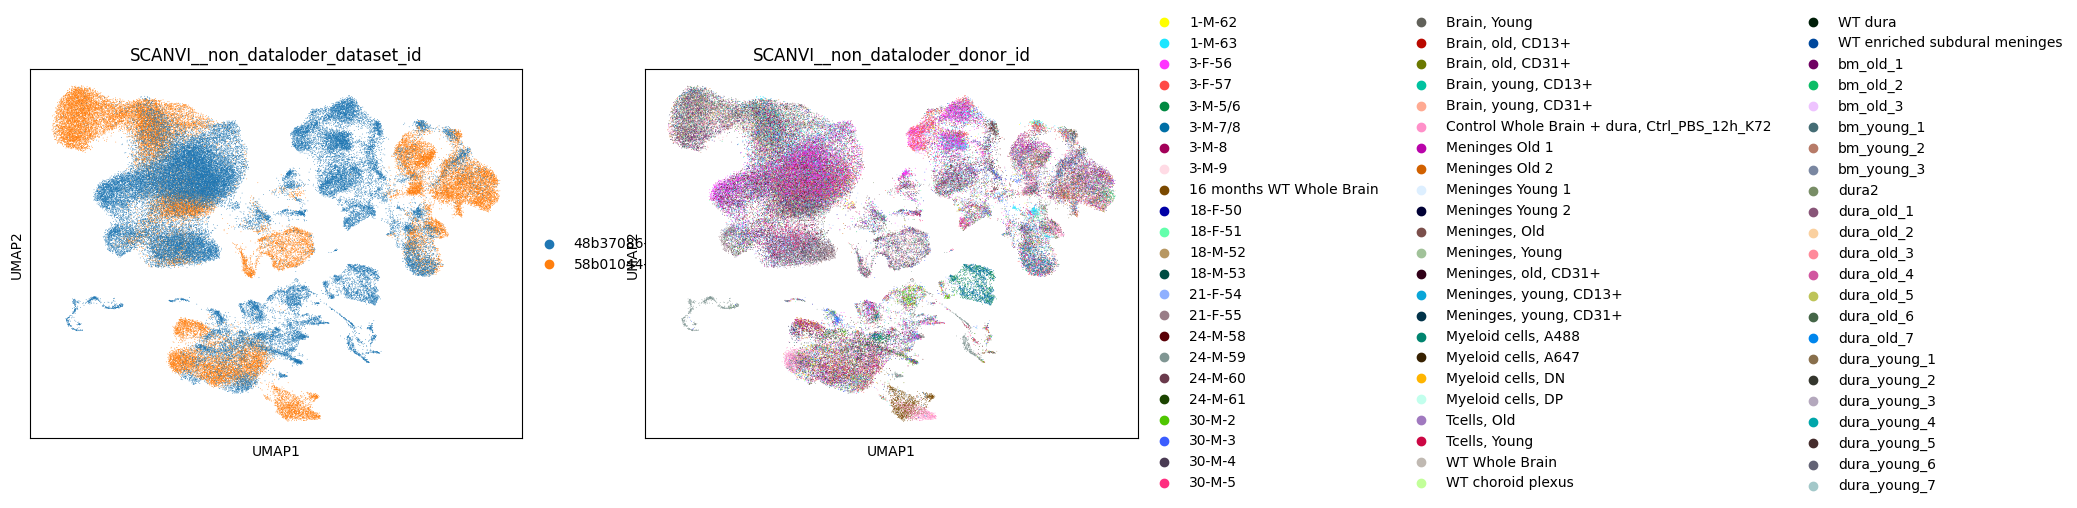

In [85]:
sc.pl.umap(
    adata,
    color=["dataset_id", "donor_id"],
    title=["SCANVI__non_dataloder_" + x for x in ["dataset_id", "donor_id"]],
)

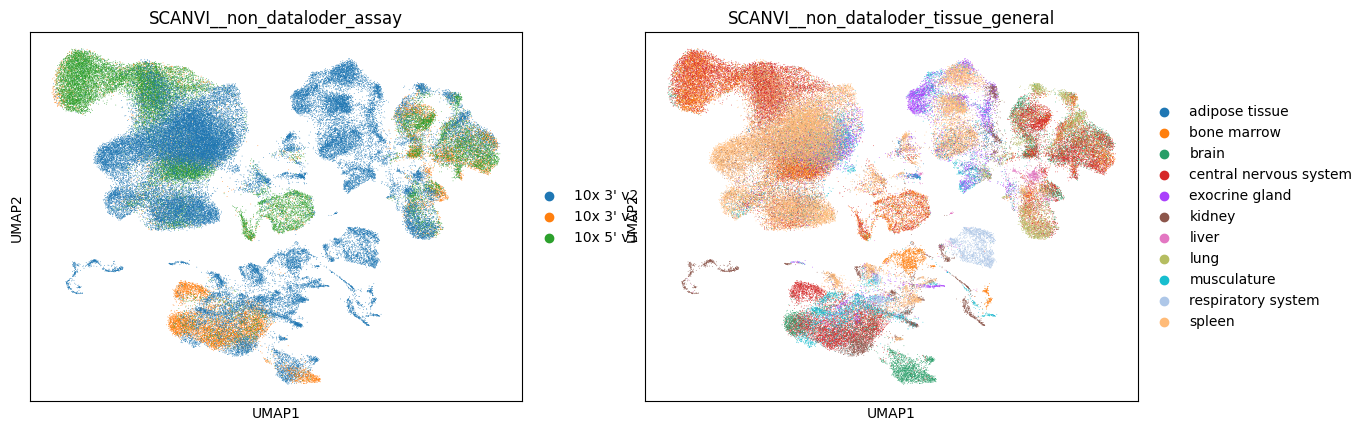

In [86]:
sc.pl.umap(
    adata,
    color=["assay", "tissue_general"],
    title=["SCANVI__non_dataloder_" + x for x in ["assay", "tissue_general"]],
)

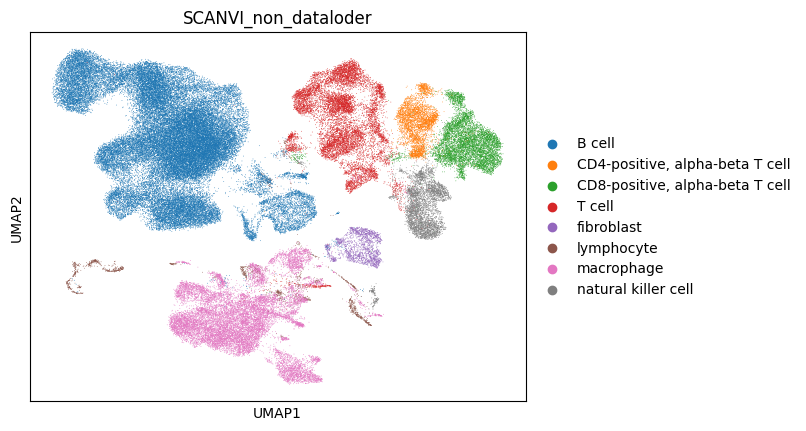

In [87]:
sc.pl.umap(adata, color="cell_type", title="SCANVI_non_dataloder")

In [88]:
adata.obs["predictions_scanvi_non_dataloder"] = model_census4.predict()

Text(0, 0.5, 'Observed')

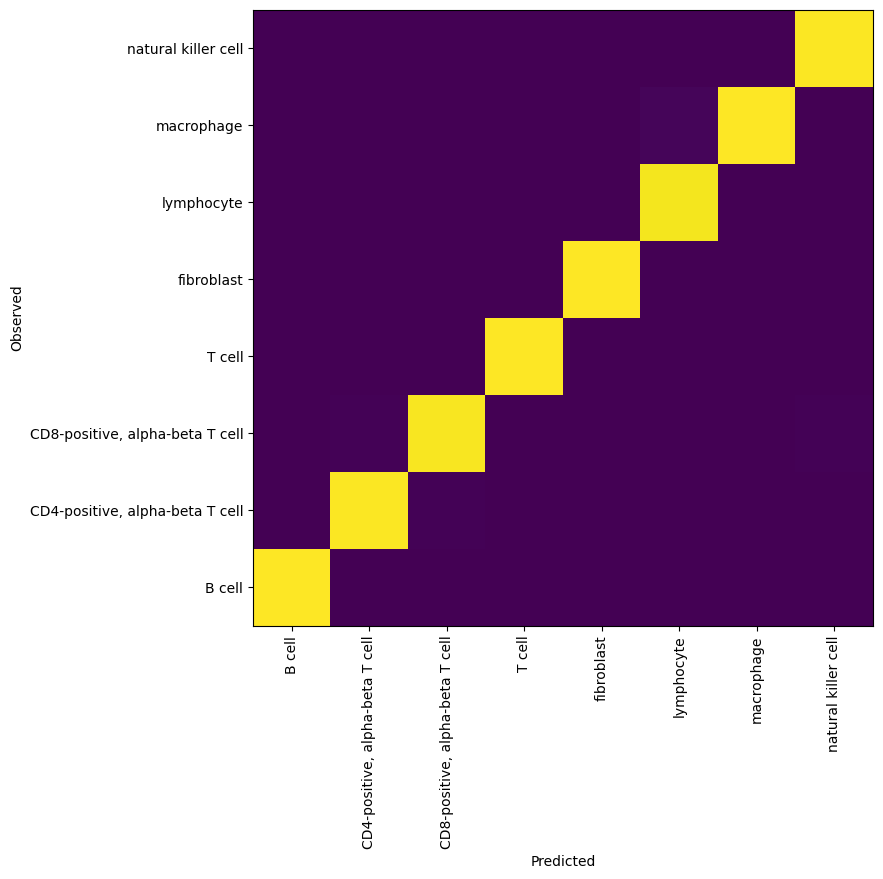

In [89]:
df = (
    adata.obs.groupby(["cell_type", "predictions_scanvi_non_dataloder"])
    .size()
    .unstack(fill_value=0)
)
norm_df = df / df.sum(axis=0)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

## Compute integration metrics

In [90]:
from scib_metrics.benchmark import Benchmarker

bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "scvi", "scvi_non_dataloder", "scanvi", "scanvi_non_dataloder"],
    n_jobs=-1,
)
bm.benchmark()

rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:11<00:06,  1.75s/it, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              



Embeddings:  20%|███████████████████████▊                                                                                               | 1/5 [00:14<00:56, 14.02s/it]
                                                                                                                                                                   
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:03<00:02,  1.58it/s, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              



Embeddings:  40%|███████████████████████████████████████████████▌                                                                       | 2/5 [00:20<00:29,  9.78s/it]
                                                                                                                                                                   
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:03<00:01,  2.10it/s, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              



Embeddings:  60%|███████████████████████████████████████████████████████████████████████▍                                               | 3/5 [00:25<00:15,  7.66s/it]
                                                                                                                                                                   
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:03<00:01,  2.08it/s, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              



Embeddings:  80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4/5 [00:31<00:06,  6.63s/it]
                                                                                                                                                                   
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:03<00:01,  2.10it/s, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              



Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.20s/it]

                                                                                                                                                                   

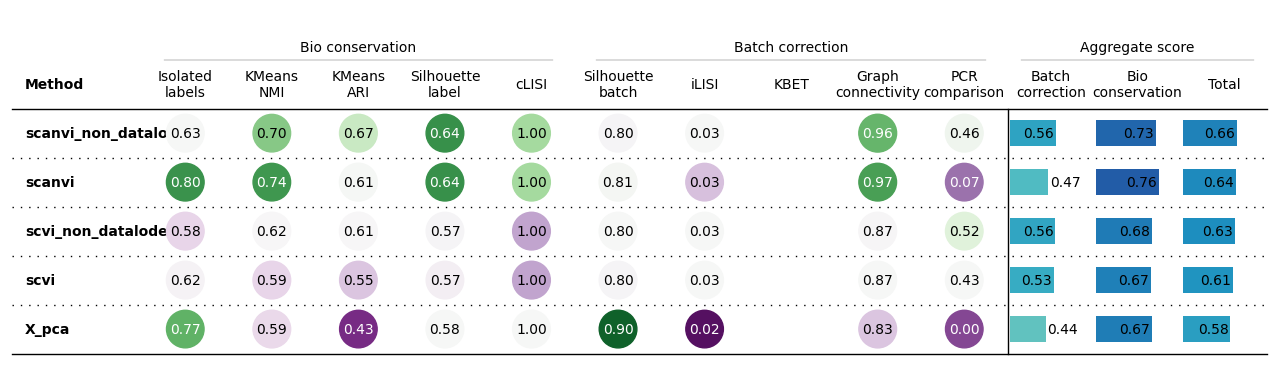

In [91]:
bm.plot_results_table(min_max_scale=False)